In [1]:
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from nndrain.tensor_edit import TensorEdit
from nndrain.simplify_linear import SimplifyLinear
import nndrain.utils as utils


utils.set_seed(777)

In [2]:
# Fully connected neural network with SimplifyLinear modules
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc = nn.ModuleList()

        # Iterate over each layer in hidden_size and create SimplifyLinear modules
        for i_l in range(len(hidden_size)+1):
            in_size = 0
            out_size = 0
            if i_l == 0:
                # For the first layer, in_size is input_size and out_size is hidden_size[0]
                in_size = input_size
                out_size = hidden_size[0]
                simplify_row = True
                simplify_col = False
                exclude_from_drain = True
            elif i_l == len(hidden_size):
                # For the last layer, in_size is hidden_size[-1] and out_size is output_size
                in_size = hidden_size[-1]
                out_size = output_size
                simplify_row = False
                simplify_col = True
                exclude_from_drain = False
            else:
                # For all other layers, in_size is hidden_size[i_l-1] and out_size is hidden_size[i_l]
                in_size = hidden_size[i_l-1]
                out_size = hidden_size[i_l]
                simplify_row = True
                simplify_col = True
                exclude_from_drain = False

            # Create a SimplifyLinear module with the appropriate parameters
            sl = SimplifyLinear(in_size, out_size, simplify_row, simplify_col, 
                                min_row=2, min_col=2, exclude_from_drain=exclude_from_drain)
            self.fc.append(sl)
            
        self.apply(self._init_weights)
        self.activation = nn.ReLU()

    def _init_weights(self, module):
        """
        Initialize weights for a given module
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, x):
        """
        Perform a forward pass through the neural network
        """
        out = x
        for i_l, l in enumerate(self.fc):
            out = self.fc[i_l](out)
            if i_l < len(self.fc)-1:
                out = self.activation(out)
        return out


In [3]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# XOR training data
x = torch.Tensor([[0, 0],[0, 1], [1, 0], [1, 1]])
y = torch.LongTensor([0, 1, 1, 0])

# Define net parameters and model
input_size = 2
hidden_size = [150, 100, 50, 20]
output_size = 2
model = Net(input_size, hidden_size, output_size).to(device)
n_start_params = sum(p.numel() for p in model.parameters())

epochs = 70000
lr = 2e-2
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

figsize = (10, 4)
outdir = 'out/xor'
is_exist = os.path.exists(outdir)
if not is_exist:
    os.makedirs(outdir)



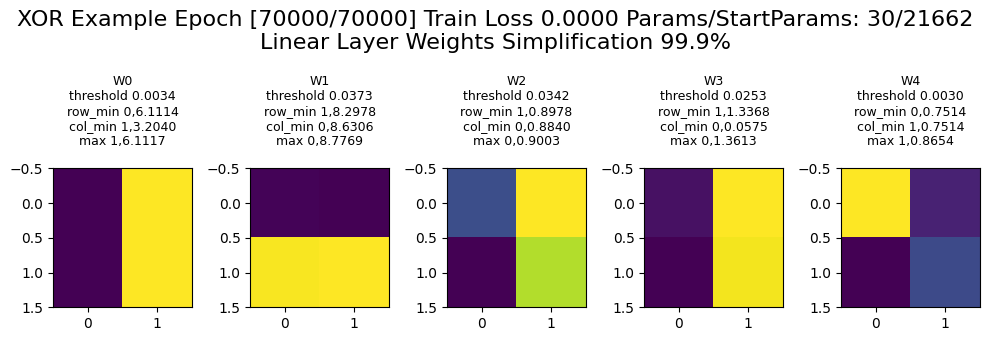

XOR Example Epoch [70000/70000] Train Loss 0.0000 Params/StartParams: 30/21662 Linear Layer Weights Simplification 99.9%


<Figure size 1000x400 with 0 Axes>

In [4]:
%matplotlib inline


# figures
fig_weight = plt.figure(figsize=figsize, facecolor='white')
filenames_weight = []
plot_epoch = 5
increment = 2
increment_limit = 1000
increment_value = 1.5

# Select the layers that can be simplified
simplify_layers = [module for module in model.modules() if isinstance(module, SimplifyLinear)]
te = TensorEdit(simplify_layers)

drain_threshold_coeff = 3.0
remove_threshold_coeff = 0.95

# Initialize lists to store loss values and epoch numbers for plot
loss_values = []
epoch_values = []
simplifications = []

# Train the model
for epoch in range(epochs):
    # Forward pass
    output = model.forward(x)
    # Calculate loss
    loss = loss_fun(output, y)
    # Backpropagate and optimize
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    te.set_threshold()
    # apply weights decay
    te.weights_drain(p_drain=0.5, threshold_coeff=drain_threshold_coeff)
    te.weights_decay(p_decay=0.5, decay_rate=5e-3)
    # Remove weights if all values in a row or column are less than the specified value
    if te.weights_remove(p_remove=0.5, threshold_coeff=remove_threshold_coeff, max_removal=1, verbose=True):
        # Re-instantiate the optimizer with the new model if any rows or columns were deleted
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    # Append current loss value and epoch number to lists for plot
    loss_values.append(loss.item())
    epoch_values.append(epoch + 1)
    # Calculate simplification as (1 - actual_params / start_params) %
    n_params = sum(p.numel() for p in model.parameters())
    simplification = (1 - n_params / n_start_params) * 100
    simplifications.append(simplification)
    
    
    # Plot weights and print progress every plot_every epochs or at the end of training
    if epoch == plot_epoch or epoch + 1 == epochs:
        plot_epoch += int(increment)
        if increment < increment_limit:
            increment += increment_value


        # Select weight matrices, transposing them for better visualization
        weights = [w.weight.data.T for w in simplify_layers]
        title1 = f"XOR Example Epoch [{epoch+1}/{epochs}] Train Loss {loss.item():.4f} Params/StartParams: {n_params}/{n_start_params}"
        title2 = f"Linear Layer Weights Simplification {simplification:.1f}%"
        ax_title = []
        for i_w, w in enumerate(weights):
            # Get minimum and maximum values for rows and columns in weight matrix
            v_min_row, i_min_row = te.get_min_weight_row_threshold(w)
            v_min_col, i_min_col = te.get_min_weight_col_threshold(w)
            v_max_row, i_max_row = te.get_max_weight_row_threshold(w)
            # Calculate remove threshold for current layer
            layer_remove_threshold = remove_threshold_coeff * simplify_layers[i_w].threshold
            # Create title for subplot with information about current layer
            ax_title.append(f"W{i_w}\nthreshold {layer_remove_threshold:.4f}\nrow_min {i_min_row},{v_min_row:.4f}\ncol_min {i_min_col},{v_min_col:.4f}\nmax {i_max_row},{v_max_row:.4f}\n")


        # Plot weights and display progress
        utils.plot_weights(fig_weight, weights, '\n'.join((title1, title2)), ax_title=ax_title)
        print(' '.join((title1, title2)))

        # Create file name and save figure
        filename = '/'.join((outdir, f'frame_weight_{epoch+1}.png'))
        filenames_weight.append(filename)
        fig_weight.savefig(filename, facecolor=fig_weight.get_facecolor())

        plt.clf()
        


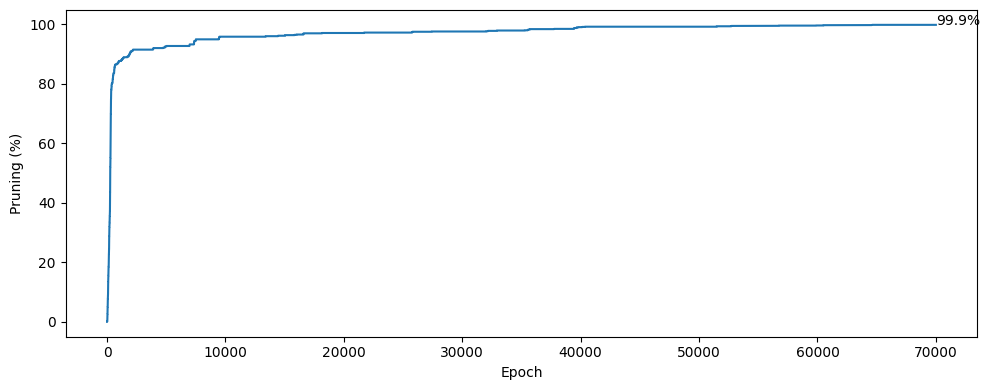

<Figure size 1000x400 with 0 Axes>

In [5]:
fig_chart = plt.figure(figsize=figsize, facecolor='white')
filenames_chart = []
plot_epoch = 5
increment = 2

for epoch in range(epochs):
    if epoch == plot_epoch or epoch + 1 == epochs:
        plot_epoch += int(increment)
        if increment < increment_limit:
            increment += increment_value

        utils.plot_charts(fig_chart, epochs=epoch_values[:epoch+1], simplifications=simplifications[:epoch+1])

        # Create file name and save figure
        filename = '/'.join((outdir, f'frame_chart_{epoch+1}.png'))
        filenames_chart.append(filename)
        fig_chart.savefig(filename, facecolor=fig_chart.get_facecolor())

        time.sleep(0.05)
        plt.clf()


In [6]:
filenames = []
# Merge vertically the two images for each frame
for idf, (fw_name, fc_name) in enumerate(zip(filenames_weight, filenames_chart)):
    # Merge the two images
    result = utils.merge_images(fw_name, fc_name)
    # Create file name and save figure
    filename = '/'.join((outdir, f'frame_{idf}.png'))
    filenames.append(filename)
    result.save(filename)

In [7]:
# build a gif by composing the frames
utils.images_to_gif(filenames, '/'.join((outdir, 'xor.gif')), tail=100)

# create a mjpg video
utils.images_to_avi(filenames, '/'.join((outdir, 'xor.avi')))

# Remove frame files
for f in set(filenames_weight):
    os.remove(f)
for f in set(filenames_chart):
    os.remove(f)
for f in set(filenames):
    os.remove(f)

In [8]:
# remove all the remaining png files
import glob

for f in glob.glob(outdir + '/*.png'):
    os.remove(f)
